In [1]:
import numpy as np
import cv2
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Intrinsic Calibration completed


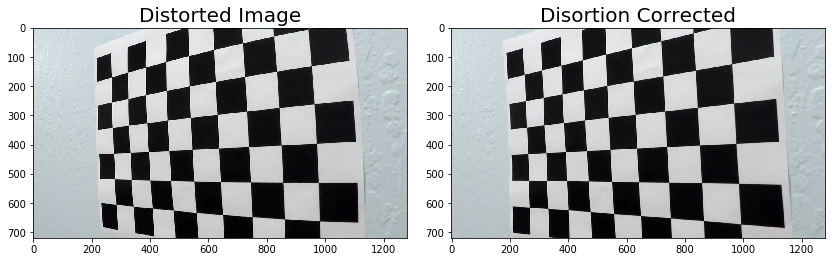

In [3]:
def intrinsic_calib():
    #Perform intrinsic calibration
    #camera world points
    cam_worldPoints = np.zeros((6*9,3), np.float32)
    cam_worldPoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    #calibration image corners 
    calibration_points = [] # 3d points in real world space
    calibration_img_corners = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    for idx,fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        #Find image point corners for calibration and stack them
        ret, img_corners = cv2.findChessboardCorners(gray,(9,6),None)
        if (ret==True):
            calibration_points.append(cam_worldPoints)
            calibration_img_corners.append(img_corners)
    
    print('Intrinsic Calibration completed')
    img_size = (img.shape[1], img.shape[0])
    ret, camera_matrix, distortion_coefficients, rvecs, tvecs = cv2.calibrateCamera(calibration_points, calibration_img_corners, img_size,None,None)
    return camera_matrix,distortion_coefficients,img_size

img_dist = cv2.imread('camera_cal/calibration4.jpg')
camera_matrix,distortion_coefficients,img_size = intrinsic_calib()
img_undist = cv2.undistort(img_dist, camera_matrix, distortion_coefficients, None, camera_matrix)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(img_dist)
ax1.set_title('Distorted Image', fontsize=20)
ax2.imshow(img_undist)
ax2.set_title('Disortion Corrected', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

imTest = cv2.imread('test_images/straight_lines1.jpg')
imTest = cv2.undistort(imTest, camera_matrix, distortion_coefficients, None, camera_matrix)


In [4]:
def set_ROI(img):
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1050, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2,right_bottom, inner_right_bottom,inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [ ]:
def get_IPM(dst_test,img_size):
    #Inverse perspective transformation
    srcpoints = np.float32([[284,682],[440,565],[860,565],[1039,682]])
    dstpoints = np.float32([[400,600],[400,500],[800,500],[800,600]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(srcpoints, dstpoints)
    Minv = cv2.getPerspectiveTransform(dstpoints, srcpoints)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(dst_test, M, img_size)
    return warped, M, Minv


In [5]:
#magnitude thresholding
def mag_thresh(imag, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = imag
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [6]:
#Direction Thresholding
def dir_threshold(imag, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = imag
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(imag, orient='x', sobel_kernel=3, thresh= (0,255)):
    # Convert to grayscale
    gray = imag
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    

    # Return the result
    return binary_output

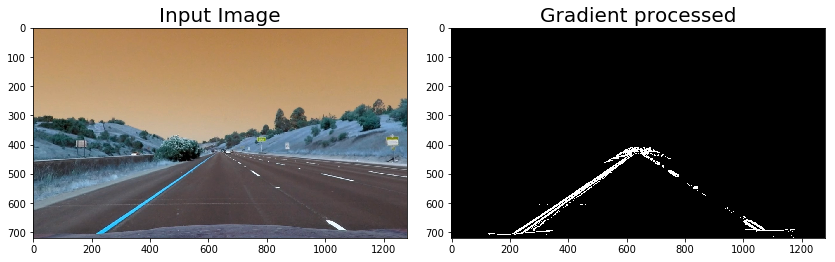

In [8]:
def gradient_processing(image):
    kernel_size = 5
    image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    ksize = 7 # Choose a larger odd number to smooth gradient measurements
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(10, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 255))
#     dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.65, 1.05))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(1.4, 1.6))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined = set_ROI(combined)
    return combined

imTest_combined = gradient_processing(imTest)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(imTest)
ax1.set_title('Input Image', fontsize=20)
ax2.imshow(imTest_combined,cmap='gray')
ax2.set_title('Gradient processed', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


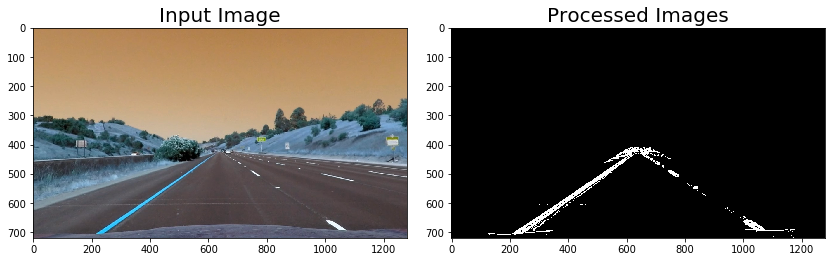

In [9]:
def color_processing(img,combined):
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    merged_binary = np.zeros_like(combined)
    merged_binary[(s_binary > 0) | (combined > 0)] = 1
    merged_binary = set_ROI(merged_binary)
    return merged_binary

imTest_combined = color_processing(imTest,imTest_combined)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(imTest)
ax1.set_title('Input Image', fontsize=20)
ax2.imshow(imTest_combined,cmap='gray')
ax2.set_title('Processed Images', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


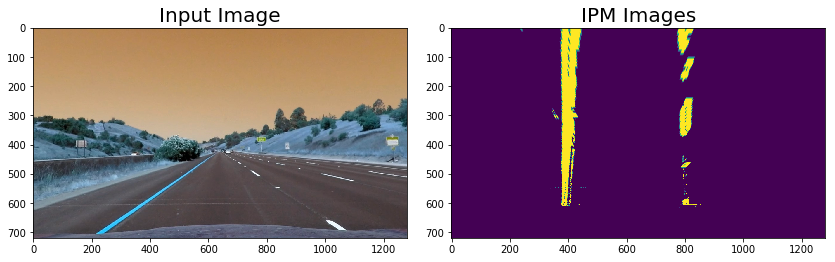

In [10]:
def get_IPM(dst_test,img_size):
    #Inverse perspective transformation
    srcpoints = np.float32([[284,682],[440,565],[860,565],[1039,682]])
    dstpoints = np.float32([[400,600],[400,500],[800,500],[800,600]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(srcpoints, dstpoints)
    Minv = cv2.getPerspectiveTransform(dstpoints, srcpoints)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(dst_test, M, img_size)
    return warped, M, Minv

warped, Pose, InvPose = get_IPM(imTest_combined,img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(imTest)
ax1.set_title('Input Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('IPM Images', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
def Radius_of_curvature(x1,y1,x2,y2,x3,y3):
    
    # source : http://www.intmath.com/applications-differentiation/8-radius-curvature.php
    m1 = (y2-y1)/(x2-x1)
    m2 = (y3-y2)/(x3-x2)
    
    xc = (m1*m2*(y1-y3)+m2*(x1+x2)-m1*(x2+x3))/(2*(m2-m1))
    yc = -(xc-(x1+x2)/2)/m1+(y1+y2)/2
    
    Radius = np.sqrt((x2-xc)*(x2-xc)+(y2-yc)*(y2-yc))
    
    return m1, m2, xc, yc, Radius

C:\Users\Vinay\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


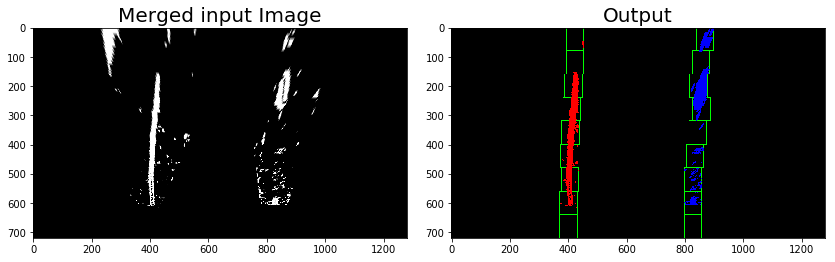

In [55]:
def histogram_calculate(combined):
    # Assuming you have created a warped binary image called "combined"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(combined[combined.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((combined, combined, combined))*255
    
    
    

    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print(leftx_base, rightx_base)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(combined.shape[0]/nwindows)
     # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 30
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combined.shape[0] - np.int((window+1)*window_height)
        win_y_high = combined.shape[0] - np.int(window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
#         print(win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
   
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
   
    return leftx, lefty, rightx, righty, out_img

leftx2, lefty2, rightx2, righty2, out_img2 = histogram_calculate(warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(warped,cmap='gray' )
ax1.set_title('Merged input Image', fontsize=20)
out_img2 = np.uint8(out_img2)
ax2.imshow(out_img2)
ax2.set_title('Output', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [27]:
def curve_fit(leftx,lefty,rightx,righty,dst_test,warped_color,M,Mi):
    img=dst_test
    yvals = np.linspace(0, img.shape[0], num=img.shape[0])

    # Fit a second order polynomial to each lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    left_xvals = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_xvals = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/400 # meteres per pixel in x dimension
    # Define y-value where we want radius of curvature
    
    # I'll choose 3 y-values(max, mean and min):
    y_eval = np.max(yvals)
    
    y_eval1 = np.max(yvals)
    y_eval2 = np.mean(yvals)
    y_eval3 = np.min(yvals)
    
    left_fitmaxx = left_fit[0]*y_eval1**2 + left_fit[1]*yvals + left_fit[2]
    left_fitmeanx = left_fit[0]*y_eval2**2 + left_fit[1]*yvals + left_fit[2]
    left_fitminx = left_fit[0]*y_eval3**2 + left_fit[1]*yvals + left_fit[2]
    right_fitmaxx = right_fit[0]*y_eval1**2 + right_fit[1]*yvals + right_fit[2]
    right_fitmeanx = right_fit[0]*y_eval2**2 + right_fit[1]*yvals + right_fit[2]
    right_fitminx = right_fit[0]*y_eval3**2 + right_fit[1]*yvals + right_fit[2]
    
    lm1, lm2, lxc, lyc, lradius = Radius_of_curvature(left_fitmaxx,y_eval1,left_fitmeanx,y_eval2,left_fitminx,y_eval3)
    rm1, rm2, rxc, ryc, rradius = Radius_of_curvature(right_fitmaxx,y_eval1,right_fitmeanx,y_eval2,right_fitminx,y_eval3)
    turning_radius = ((lradius)+(rradius))/2
    left_mean = np.mean(leftx)
    right_mean = np.mean(rightx)
    camera_pos = (combined.shape[1]/2)-np.mean([left_mean, right_mean])
    
    pts_left = np.array([np.transpose(np.vstack([left_xvals, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_xvals, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    warp_zero = np.zeros_like(warped_color).astype(np.uint8)
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    cv2.polylines(warp_zero, np.array([pts_left], dtype=np.int32), False,(255,0,0),thickness = 15)
    cv2.polylines(warp_zero, np.array([pts_right], dtype=np.int32), False,(0,0,255),thickness = 15)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,'Car Position' + ' [' + str(camera_pos*xm_per_pix)[:6] + '] m',(10,30), font, 1,(255,255,255),2)
    cv2.putText(img,'Radius of curvature '+ str(turning_radius)[:6] + '] m' ,(10,60), font, 1,(255,255,255),2)
        
    unwarp = cv2.warpPerspective(warp_zero, Mi,(img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(dst_test, 1, unwarp, 0.3, 0)
    #result = cv2.resize(result, (720, 405))

    return result,warp_zero


C:\Users\Vinay\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


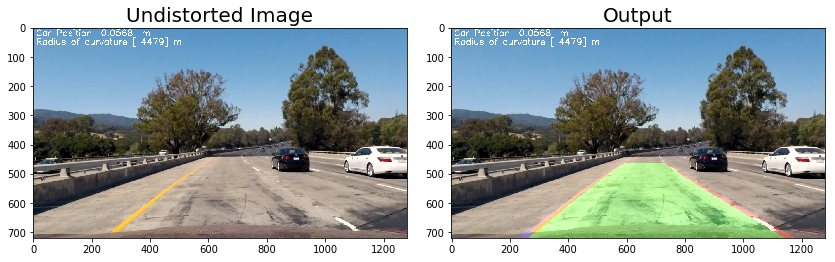

In [56]:
#load test image
img_test = cv2.imread('test_images/test1.jpg')
camera_matrix,distortion_coefficients,img_size = intrinsic_calib()
dst_test = cv2.undistort(img_test, camera_matrix, distortion_coefficients, None, camera_matrix)
combined = gradient_processing(dst_test)
merged_binary = color_processing(dst_test,combined)
warped, Pose, InvPose = get_IPM(merged_binary,img_size)
warped_color, Pose, InvPose = get_IPM(dst_test,img_size)
leftx, lefty, rightx, righty, out_img = histogram_calculate(warped)
result,warp_zero = curve_fit(leftx,lefty,rightx,righty,dst_test,warped_color,Pose,InvPose)

result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
dst_test = cv2.cvtColor(dst_test,cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(dst_test)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(result,cmap='gray' )
ax2.set_title('Output', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [57]:
def process_img(image):
    img_test = image#cv2.imread('test_images/straight_lines1.jpg')
    # camera_matrix,distortion_coefficients,img_size = intrinsic_calib()
    dst_test = cv2.undistort(img_test, camera_matrix, distortion_coefficients, None, camera_matrix)
    combined = gradient_processing(dst_test)
    merged_binary = color_processing(dst_test,combined)
    warped, Pose, InvPose = get_IPM(merged_binary,img_size)
    warped_color, Pose, InvPose = get_IPM(dst_test,img_size)
    leftx, lefty, rightx, righty, out_img = histogram_calculate(warped)
    result,warp_zero = curve_fit(leftx,lefty,rightx,righty,dst_test,warped_color,Pose,InvPose)

    return result

In [58]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_final.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


100%|█████████████████████████████████████▉| 1260/1261 [24:13<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

Wall time: 24min 15s
